In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
data_folder_name = 'dl-itba-cifar-100-2024-q-1'

def getFileNames(folder_name):
    
    path = os.path.join(os.getcwd(),'..','..',folder_name)
    file_names = os.listdir(path)

    return file_names 

print(getFileNames(data_folder_name))

['coarse_label_names.pck', 'fine_label_names.pck', 'x_test.npy', 'x_train.npy', 'y_train_coarse.npy', 'y_train_fine.npy']


In [3]:
file_names = getFileNames(data_folder_name)

# Lectura de archivos '.npy' 

x_test = np.load('../'+'../'+data_folder_name+'/'+file_names[2])
x_train = np.load('../'+'../'+data_folder_name+'/'+file_names[3])
y_train_coarse = np.load('../'+'../'+data_folder_name+'/'+file_names[4])
y_train_fine = np.load('../'+'../'+data_folder_name+'/'+file_names[5])

# Lectura de archivos '.pck'

with open('../'+'../'+data_folder_name+'/'+file_names[0], "rb") as f:
    coarse_label_names = pickle.load(f)
f.close()

with open('../'+'../'+data_folder_name+'/'+file_names[1], "rb") as f:
    fine_label_names = pickle.load(f)
f.close()

print('Dimensiones de los datos:')
print(x_test.shape)
print(x_train.shape)
print(y_train_coarse.shape)
print(y_train_fine.shape)

print('Cantidad de clases:')
print(np.shape(coarse_label_names))
print(np.shape(fine_label_names))

Dimensiones de los datos:
(10000, 32, 32, 3)
(50000, 32, 32, 3)
(50000,)
(50000,)
Cantidad de clases:
(20,)
(100,)


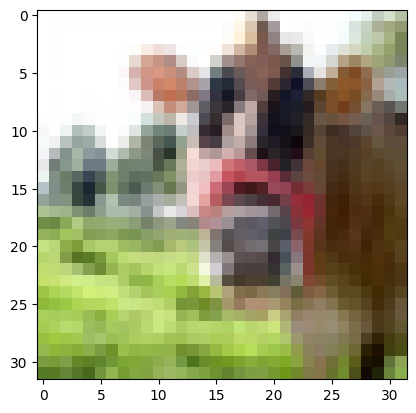

In [4]:
plt.imshow(x_train[0])
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

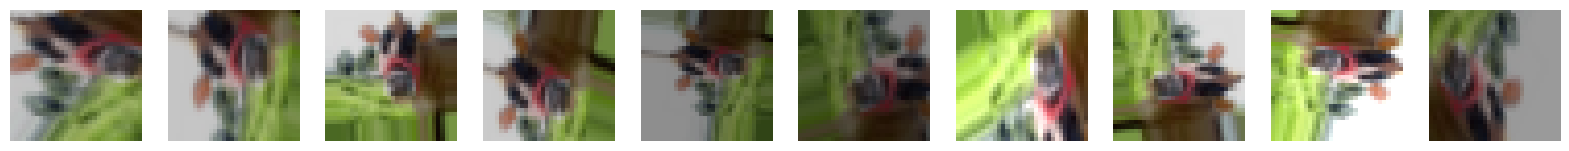

In [32]:
# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.3,1.2]
)

# Load the original image
img = x_train[0]

# Reshape the image to a 4D tensor with shape (1, height, width, channels)
img = img.reshape((1,) + img.shape)

# Generate augmented images
augmented_images = []
for batch in datagen.flow(img, batch_size=1):
    augmented_images.append(batch[0])
    if len(augmented_images) >= 10:
        break  # Stop the loop after generating 5 augmented images

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(augmented_images):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(np.uint8(img))
    ax.axis('off')
plt.show()

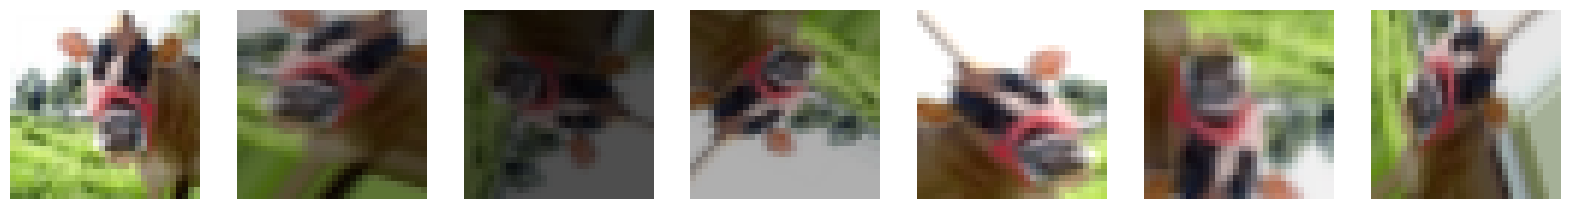

In [80]:
def dataAugmentation4Img(img,num_new_data):
    
    """
    Devuelve un array de '1+num_new_data' imágenes, siendo el primer elemento la imagen original.
    """
    
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        brightness_range=[0.3,1.5])
    
    img = img.reshape((1,) + img.shape)
    
    augmented_images = np.array(np.uint8([batch[0] for batch, iter in zip(datagen.flow(img, batch_size=1),np.arange(num_new_data))]))
    
    augmented_images = np.concatenate((img, augmented_images), axis=0)
    
    return augmented_images

num_new_data = 6
newdata = dataAugmentation4Img(x_train[0],num_new_data)

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(newdata):
    ax = fig.add_subplot(1, len(newdata), i+1)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [89]:
def labels4dataAugmentation4Img(img_label,num_new_data):
    
    """
    Devuelve un array de '1+num_new_data' labels, siendo el primer elemento el label de la imagen original.
    """
    
    augmented_labels = np.array([img_label for i in np.arange(num_new_data+1)])
    
    return augmented_labels
    
print(labels4dataAugmentation4Img(y_train_coarse[0],num_new_data))

[11 11 11 11 11 11 11]


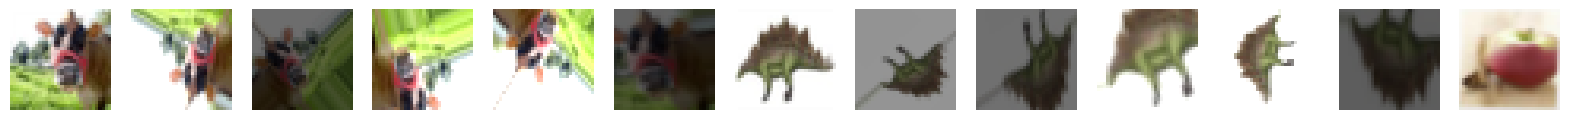

[19 19 19 19 19 19 29 29 29 29 29 29  0]
[11 11 11 11 11 11 15 15 15 15 15 15  4]


In [131]:
def dataAugmentation4ImgBatch(img_batch,img_labels,num_new_data):
    
    
    # Creación de/del vector/vectores de labels
    
    labels = []
    
    for i in range(len(img_labels)):
        
        list_labels_4_img = np.array([labels4dataAugmentation4Img(img_label,num_new_data) for img_label in img_labels[i]])
        
        list_labels_4_img = np.hstack(list_labels_4_img)
        
        labels.append(list_labels_4_img)      
        
    # Creación del vector de imágenes
    
    list_new_data_4_img = np.array([dataAugmentation4Img(img,num_new_data) for img in img_batch])
    
    stack_imgs = np.concatenate(list_new_data_4_img,axis=0)
    
    return stack_imgs, labels

stack_imgs, labels = dataAugmentation4ImgBatch(x_train[:3],[y_train_fine[:3],y_train_coarse[:3]],num_new_data=5)

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(stack_imgs[:13]):
    ax = fig.add_subplot(1, len(stack_imgs[:13]), i+1)
    ax.imshow(img)
    ax.axis('off')
plt.show()

print(labels[0][:13])
print(labels[1][:13])


In [141]:
def savenpyData(arr_x,arr_y_list,name_extern_folder='prueba_guardado',type='train'):
    
    path_extern_folder = os.path.join(os.getcwd(), '..', '..', name_extern_folder)

    if not os.path.exists(path_extern_folder):
        os.makedirs(path_extern_folder)

    # Guardado de labels
    for i in range(len(arr_y_list)):
        np.save(os.path.join(path_extern_folder, f'y_{type}_{i}.npy'), arr_y_list[i])
    
    # Guardado de imgs
    np.save(os.path.join(path_extern_folder, f'x_{type}.npy'), arr_x)
    

In [146]:
savenpyData(stack_imgs,labels,name_extern_folder='prueba',type='sub_train_aug')

['x_sub_train_aug.npy', 'y_sub_train_aug_0.npy', 'y_sub_train_aug_1.npy']


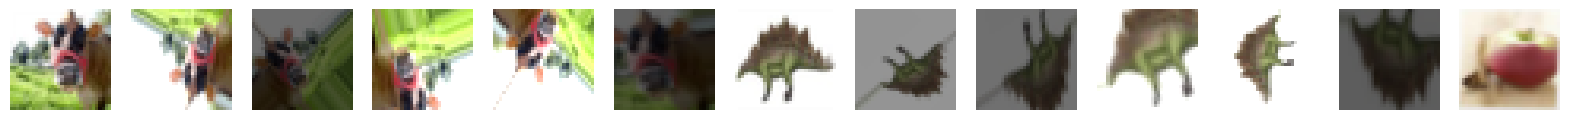

[19 19 19 19 19 19 29 29 29 29 29 29  0]
[11 11 11 11 11 11 15 15 15 15 15 15  4]


In [150]:
print(getFileNames('prueba'))

x_sub_train_aug = np.load('../'+'../'+'prueba'+'/'+getFileNames('prueba')[0])
y_sub_train_aug_0 = np.load('../'+'../'+'prueba'+'/'+getFileNames('prueba')[1])
y_sub_train_aug_1 = np.load('../'+'../'+'prueba'+'/'+getFileNames('prueba')[2])

fig = plt.figure(figsize=(20,5))
for i, img in enumerate(x_sub_train_aug[:13]):
    ax = fig.add_subplot(1, len(x_sub_train_aug[:13]), i+1)
    ax.imshow(img)
    ax.axis('off')
plt.show()

print(y_sub_train_aug_0[:13])
print(y_sub_train_aug_1[:13])